## MMBTの学習にStratifiedKfoldでそれぞれの学習モデルの結果の平均値を学習結果として提出

`1.3 MMBT_stratified_shuffle_kfold_model.ipynb` との違いは、StratifiedShuffleSplit => StratifiedKFoldに変更している点

こちらの方法だと以下の相違点がある。

- 全てのデータが学習に用いられることになる。

- 予測モデルを用いてstackingなども一応可能

In [2]:
import os
import random
from pathlib import Path
import sys
import json
from glob import glob

import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold
from scipy.special import softmax
from transformers import (
    AutoTokenizer, Trainer, TrainingArguments,
)
from torchvision.models import ResNet152_Weights

sys.path.append('../')
from src.data.prepare import load_base_df
from src.models.MMBT.dataset import (BokeTextImageDataset, collate_fn)
from src.models.MMBT.mmbt import load_model
from src.models.utils import fix_seed, plot_confusion_matrix

In [1]:
SEED_SHUFFLE = 0
SEED_TRAIN = 0

## データ読み込み

In [3]:
train_df, test_df, submission_df = load_base_df('../dataset/csv/', '../dataset/imgs/')

In [4]:
print(f'train_df.shape: {train_df.shape}')
display(train_df.head())

print(f'test_df.shape: {test_df.shape}')
display(test_df.head())

train_df.shape: (24962, 5)


,id,odai_photo_file_name,text,is_laugh,img_path
0,ge5kssftl,9fkys1gb2r.jpg,君しょっちゅうソレ自慢するけど、ツムジ２個ってそんなに嬉しいのかい？,0,../dataset/imgs/train/9fkys1gb2r.jpg
1,r7sm6tvkj,c6ag0m1lak.jpg,これでバレない？授業中寝てもバレない？,0,../dataset/imgs/train/c6ag0m1lak.jpg
2,yp5aze0bh,whtn6gb9ww.jpg,「あなたも感じる？」\n『ああ…、感じてる…』\n「後ろに幽霊いるよね…」\n『女のな…』,0,../dataset/imgs/train/whtn6gb9ww.jpg
3,ujaixzo56,6yk5cwmrsy.jpg,大塚愛聞いてたらお腹減った…さく、らんぼと牛タン食べたい…,0,../dataset/imgs/train/6yk5cwmrsy.jpg
4,7vkeveptl,0i9gsa2jsm.jpg,熊だと思ったら嫁だった,0,../dataset/imgs/train/0i9gsa2jsm.jpg


test_df.shape: (6000, 5)


,id,odai_photo_file_name,text,img_path,is_laugh
0,rfdjcfsqq,nc1kez326b.jpg,僕のママ、キャラ弁のゆでたまごに８時間かかったんだ,../dataset/imgs/test/nc1kez326b.jpg,0
1,tsgqmfpef,49xt2fmjw0.jpg,かわいいが作れた！,../dataset/imgs/test/49xt2fmjw0.jpg,0
2,owjcthkz2,9dtscjmyfh.jpg,来世の志茂田景樹,../dataset/imgs/test/9dtscjmyfh.jpg,0
3,rvgaocjyy,osa3n56tiv.jpg,ちょ、あの、オカン、これ水風呂やねんけど、なんの冗談??,../dataset/imgs/test/osa3n56tiv.jpg,0
4,uxtwu5i69,yb1yqs4pvb.jpg,「今日は皆さんにザリガニと消防車の違いを知ってもらいたいと思います」『どっちも同じだろ。両方...,../dataset/imgs/test/yb1yqs4pvb.jpg,0


## データ準備, 学習

In [5]:
BATCH_SIZE = 8
EPOCHS = 3
GRADIENT_ACCUMULATION_STEPS = 20
SAVE_STEPS = 25


def create_trainer(
            model,
            model_dst,
            train_ds,
            valid_ds,
            train_batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
            save_steps=SAVE_STEPS
        ):
    trainer_args = TrainingArguments(
        output_dir=str(model_dst),
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        num_train_epochs=epochs,
        evaluation_strategy="steps",
        eval_steps=save_steps,
        save_strategy="steps",
        save_steps=save_steps,
        logging_steps=save_steps,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=12,
        save_total_limit=1,
        fp16=True,
        remove_unused_columns=False,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        load_best_model_at_end=True,
        logging_dir='./logs',
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=trainer_args,
        tokenizer=tokenizer,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        data_collator=collate_fn,
    )
    return trainer

In [6]:
MAX_SEQENCE_LEN = 48
N_SPLIT = 5

# 結果保存用ディレクトリ準備
EXPERIMENT_NAME = f'{N_SPLIT}fold_stratified_mmbt_seed_{SEED_SHUFFLE}'
MODEL_DIR = Path('../model/') / EXPERIMENT_NAME
MODEL_DIR.mkdir(exist_ok=True, parents=True)
PLOT_DIR = Path('../plots') / EXPERIMENT_NAME
PLOT_DIR.mkdir(exist_ok=True, parents=True)
RESULT_DIR = Path('../results/') / EXPERIMENT_NAME
RESULT_DIR.mkdir(exist_ok=True, parents=True)

k=1


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82

  0%|          | 0.00/230M [00:00<?, ?B/s]

Using cuda_amp half precision backend
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 19969
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 160
  Gradient Accumulation steps = 20
  Total optimization steps = 372


Step,Training Loss,Validation Loss
25,0.691900,0.667191
50,0.666100,0.654875
75,0.669100,0.653369
100,0.658800,0.653454
125,0.675700,0.650319
150,0.627400,0.646333
175,0.623900,0.668304
200,0.623200,0.645816
225,0.616400,0.641685
250,0.633700,0.660785


***** Running Evaluation *****
  Num examples = 4993
  Batch size = 12
Saving model checkpoint to ../model/5fold_stratified_mmbt_seed_0/fold_1/checkpoint-25
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in ../model/5fold_stratified_mmbt_seed_0/fold_1/checkpoint-25/tokenizer_config.json
Special tokens file saved in ../model/5fold_stratified_mmbt_seed_0/fold_1/checkpoint-25/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4993
  Batch size = 12
Saving model checkpoint to ../model/5fold_stratified_mmbt_seed_0/fold_1/checkpoint-50
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in ../model/5fold_stratified_mmbt_seed_0/fold_1/checkpoint-50/tokenizer_config.json
Special tokens file saved in ../model/5fold_stratified_mmbt_seed_0/fold_1/checkpoint-50/special_tokens_map.json
Deleting older checkpoint [../model/5fold_stratified_mmbt_seed_0/fold_1/checkpoint-25] due to args

***** Running Prediction *****
  Num examples = 6000
  Batch size = 12


k=2


loading configuration file https://huggingface.co/cl-tohoku/bert-base-japanese-whole-word-masking/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/573af37b6c39d672f2df687c06ad7d556476cbe43e5bf7771097187c45a3e7bf.abeb707b5d79387dd462e8bfb724637d856e98434b6931c769b8716c6f287258
Model config BertConfig {
  "_name_or_path": "cl-tohoku/bert-base-japanese-whole-word-masking",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertJapaneseTokenizer",
  "transformers_version": "4.21.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32

Step,Training Loss,Validation Loss
25,0.675800,0.681878
50,0.682200,0.661510
75,0.667900,0.660999
100,0.652700,0.661653
125,0.686600,0.653382
150,0.630700,0.654538
175,0.632500,0.648594
200,0.620600,0.650235
225,0.623500,0.650301
250,0.652900,0.661756


***** Running Evaluation *****
  Num examples = 4993
  Batch size = 12
Saving model checkpoint to ../model/5fold_stratified_mmbt_seed_0/fold_2/checkpoint-25
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in ../model/5fold_stratified_mmbt_seed_0/fold_2/checkpoint-25/tokenizer_config.json
Special tokens file saved in ../model/5fold_stratified_mmbt_seed_0/fold_2/checkpoint-25/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4993
  Batch size = 12
Saving model checkpoint to ../model/5fold_stratified_mmbt_seed_0/fold_2/checkpoint-50
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in ../model/5fold_stratified_mmbt_seed_0/fold_2/checkpoint-50/tokenizer_config.json
Special tokens file saved in ../model/5fold_stratified_mmbt_seed_0/fold_2/checkpoint-50/special_tokens_map.json
Deleting older checkpoint [../model/5fold_stratified_mmbt_seed_0/fold_2/checkpoint-25] due to args

***** Running Prediction *****
  Num examples = 6000
  Batch size = 12


k=3


loading configuration file https://huggingface.co/cl-tohoku/bert-base-japanese-whole-word-masking/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/573af37b6c39d672f2df687c06ad7d556476cbe43e5bf7771097187c45a3e7bf.abeb707b5d79387dd462e8bfb724637d856e98434b6931c769b8716c6f287258
Model config BertConfig {
  "_name_or_path": "cl-tohoku/bert-base-japanese-whole-word-masking",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertJapaneseTokenizer",
  "transformers_version": "4.21.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32

Step,Training Loss,Validation Loss
25,0.682200,0.664253
50,0.662900,0.665447
75,0.679700,0.656146
100,0.654500,0.665350
125,0.678500,0.664789
150,0.631500,0.676167
175,0.632600,0.670947
200,0.636300,0.642682
225,0.623900,0.645021
250,0.642000,0.640677


***** Running Evaluation *****
  Num examples = 4992
  Batch size = 12
Saving model checkpoint to ../model/5fold_stratified_mmbt_seed_0/fold_3/checkpoint-25
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in ../model/5fold_stratified_mmbt_seed_0/fold_3/checkpoint-25/tokenizer_config.json
Special tokens file saved in ../model/5fold_stratified_mmbt_seed_0/fold_3/checkpoint-25/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4992
  Batch size = 12
Saving model checkpoint to ../model/5fold_stratified_mmbt_seed_0/fold_3/checkpoint-50
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in ../model/5fold_stratified_mmbt_seed_0/fold_3/checkpoint-50/tokenizer_config.json
Special tokens file saved in ../model/5fold_stratified_mmbt_seed_0/fold_3/checkpoint-50/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4992
  Batch size = 12
Saving model checkpoint to 

***** Running Prediction *****
  Num examples = 6000
  Batch size = 12


k=4


loading configuration file https://huggingface.co/cl-tohoku/bert-base-japanese-whole-word-masking/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/573af37b6c39d672f2df687c06ad7d556476cbe43e5bf7771097187c45a3e7bf.abeb707b5d79387dd462e8bfb724637d856e98434b6931c769b8716c6f287258
Model config BertConfig {
  "_name_or_path": "cl-tohoku/bert-base-japanese-whole-word-masking",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertJapaneseTokenizer",
  "transformers_version": "4.21.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32

Step,Training Loss,Validation Loss
25,0.676300,0.674574
50,0.659300,0.668474
75,0.674000,0.656520
100,0.661500,0.664410
125,0.685300,0.655044
150,0.636900,0.651540
175,0.634800,0.654808
200,0.624800,0.661675
225,0.636800,0.676329
250,0.656900,0.645525


***** Running Evaluation *****
  Num examples = 4992
  Batch size = 12
Saving model checkpoint to ../model/5fold_stratified_mmbt_seed_0/fold_4/checkpoint-25
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in ../model/5fold_stratified_mmbt_seed_0/fold_4/checkpoint-25/tokenizer_config.json
Special tokens file saved in ../model/5fold_stratified_mmbt_seed_0/fold_4/checkpoint-25/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4992
  Batch size = 12
Saving model checkpoint to ../model/5fold_stratified_mmbt_seed_0/fold_4/checkpoint-50
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in ../model/5fold_stratified_mmbt_seed_0/fold_4/checkpoint-50/tokenizer_config.json
Special tokens file saved in ../model/5fold_stratified_mmbt_seed_0/fold_4/checkpoint-50/special_tokens_map.json
Deleting older checkpoint [../model/5fold_stratified_mmbt_seed_0/fold_4/checkpoint-25] due to args

***** Running Prediction *****
  Num examples = 6000
  Batch size = 12


k=5


loading configuration file https://huggingface.co/cl-tohoku/bert-base-japanese-whole-word-masking/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/573af37b6c39d672f2df687c06ad7d556476cbe43e5bf7771097187c45a3e7bf.abeb707b5d79387dd462e8bfb724637d856e98434b6931c769b8716c6f287258
Model config BertConfig {
  "_name_or_path": "cl-tohoku/bert-base-japanese-whole-word-masking",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertJapaneseTokenizer",
  "transformers_version": "4.21.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32

Step,Training Loss,Validation Loss
25,0.682400,0.658570
50,0.657400,0.667176
75,0.673500,0.650749
100,0.656000,0.668191
125,0.679100,0.648665
150,0.631500,0.649902
175,0.618700,0.643331
200,0.617900,0.678268
225,0.624600,0.655706
250,0.626300,0.656888


***** Running Evaluation *****
  Num examples = 4992
  Batch size = 12
Saving model checkpoint to ../model/5fold_stratified_mmbt_seed_0/fold_5/checkpoint-25
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in ../model/5fold_stratified_mmbt_seed_0/fold_5/checkpoint-25/tokenizer_config.json
Special tokens file saved in ../model/5fold_stratified_mmbt_seed_0/fold_5/checkpoint-25/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4992
  Batch size = 12
Saving model checkpoint to ../model/5fold_stratified_mmbt_seed_0/fold_5/checkpoint-50
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
tokenizer config file saved in ../model/5fold_stratified_mmbt_seed_0/fold_5/checkpoint-50/tokenizer_config.json
Special tokens file saved in ../model/5fold_stratified_mmbt_seed_0/fold_5/checkpoint-50/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4992
  Batch size = 12
Saving model checkpoint to 

***** Running Prediction *****
  Num examples = 6000
  Batch size = 12


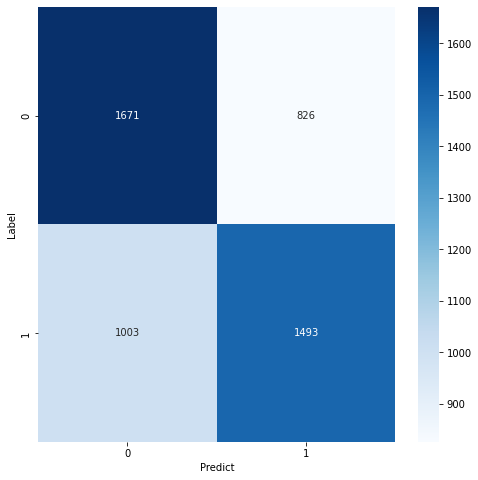

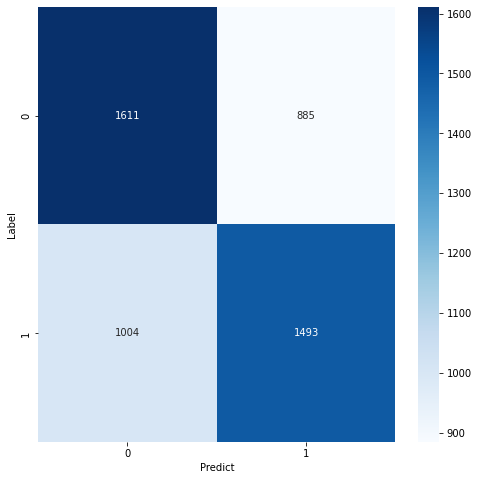

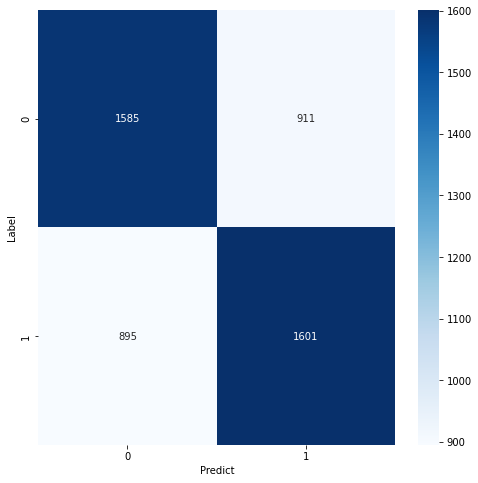

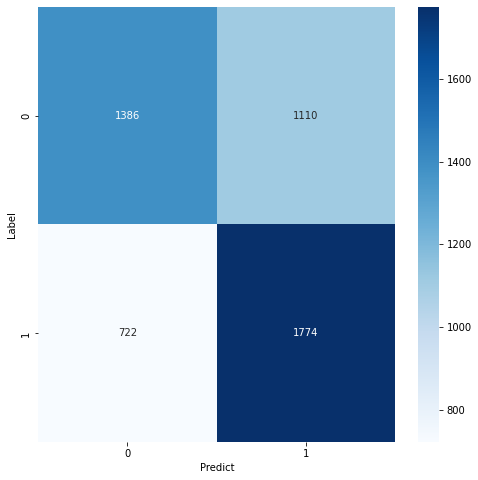

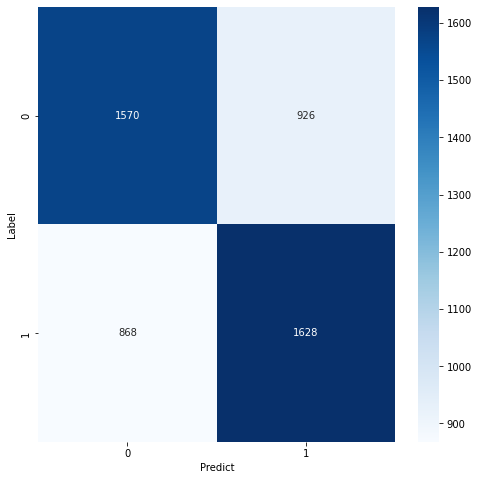

In [7]:
# seed固定
fix_seed(SEED_TRAIN)

# tokenizerとtest_ds準備
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")
test_ds = BokeTextImageDataset(test_df, tokenizer, MAX_SEQENCE_LEN, image_transform=ResNet152_Weights.IMAGENET1K_V2)

# k-fold用インスタンス生成
sk = StratifiedKFold(n_splits=N_SPLIT, random_state=SEED_SHUFFLE, shuffle=True)
for i, (train_idx, valid_idx) in enumerate(sk.split(train_df, train_df['is_laugh'])):
    k = i + 1
    print(f'k={k}')
    # 学習 => MODEL_DIR配下に fold_{k}という名前で結果を保存
    model = load_model()
    model_dst = MODEL_DIR / f'fold_{k}'
    train_ds = BokeTextImageDataset(
        train_df.iloc[train_idx],
        tokenizer,
        MAX_SEQENCE_LEN,
        ResNet152_Weights.IMAGENET1K_V2
    )
    valid_ds = BokeTextImageDataset(
        train_df.iloc[valid_idx],
        tokenizer,
        MAX_SEQENCE_LEN,
        ResNet152_Weights.IMAGENET1K_V2
    )
    trainer = create_trainer(model, model_dst, train_ds, valid_ds)
    trainer.train()

    # 予測
    val_preds = trainer.predict(valid_ds).predictions

    # 評価(混同行列) => PLOT_DIR配下に fold_i_conf_matrix.pngという名前で結果を保存
    plot_confusion_matrix(y_true=valid_ds.df['is_laugh'].values, y_pred=val_preds, dst=str(PLOT_DIR / f'fold_{k}_conf_matrix.png'))

    # 評価(log_lossとaccuracy) => RESULT_DIR配下にfold_i_log.jsonという名前で結果を保存(このjsonにlog_loss, accuracy, 学習に使用したtrain_idx, valdi_idxを保存しておく)
    loss = log_loss(valid_ds.df["is_laugh"].values, softmax(val_preds, axis=-1))
    acc = accuracy_score(valid_ds.df['is_laugh'].values, np.argmax(val_preds, axis=-1))
    logs = {
        'log_loss': float(loss),
        'acc': float(acc),
        'train_idx': train_idx.tolist(),
        'valid_idx': valid_idx.tolist()
    }
    with open(str(RESULT_DIR / f'fold_{k}_log.json'), 'w') as f:
        json.dump(logs, f)

    # csv保存 => RESULT_DIR配下にfold_i_submission.csvという名前で結果を保存
    y_pred = trainer.predict(test_ds).predictions
    submission_df['is_laugh'] = softmax(y_pred, axis=1)[:, 1]
    submission_df["is_laugh"] = submission_df["is_laugh"].astype(float)
    output = str(RESULT_DIR / f'fold_{k}_submission.csv')
    submission_df.to_csv(output, index=False)

In [11]:
json_path_list = list(glob(str(RESULT_DIR / '*.json')))
acc_list = []
log_loss_list = []
for json_path in json_path_list:
    with open(json_path, 'r') as f:
        data = json.load(f)
    acc_list.append(data['acc'])
    log_loss_list.append(data['log_loss'])
print(f'acc mean: {np.mean(acc_list):.4f}, std: {np.std(acc_list):.4f}')
print(f'log loss mean: {np.mean(log_loss_list):.4f}, std: {np.std(log_loss_list):.4f}')

acc mean: 0.6334, std: 0.0065
log loss mean: 0.6439, std: 0.0028


In [13]:
csv_path_list = list(glob(str(RESULT_DIR / 'fold_*_submission.csv')))
is_laugh_arr = np.stack([pd.read_csv(csv_path)['is_laugh'] for csv_path in csv_path_list])
is_laugh_mean = np.mean(is_laugh_arr, axis=0)
submission_df['is_laugh'] = is_laugh_mean
output = str(RESULT_DIR / f'5fold_mean_submission.csv')
submission_df.to_csv(output, index=False)